In [1]:
from modules import node, bandits, system
from modules import utils
from configs import config

import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# Load data
with open('../data/channel_data_bs_5_140_ghz', 'rb') as fp:
    dataset_1 = pickle.load(fp)

# with open('../data/channel_data_round_2.pickle', 'rb') as fp:
#     dataset_2 = pickle.load(fp)

# with open('../data/channel_data_round_3.pickle', 'rb') as fp:
#     dataset_3 = pickle.load(fp)

# Create the channel and location data
H_1, loc_1 = utils.craft_data(dataset_1)
# H_2, loc_2 = utils.craft_data(dataset_2)
# H_3, loc_3 = utils.craft_data(dataset_3)

# concatenate the data
H = np.concatenate([H_1], axis=0)
loc = np.concatenate([loc_1], axis=0)

Before discarding zero data:  (8065, 4, 16) (8065, 2)
After discarding zero data:  (8064, 4, 16) (8064, 2)


In [3]:
# System configuration
# BS: 16 antennas and codebook size of 8
N_b = 16
M_b = 8

# UE: 4 antennas and codebook size of 4
N_u = 4
M_u = 4

# Location of BS
x_bs = dataset_1[0]['basestation']['location'][0][0]
y_bs = dataset_1[0]['basestation']['location'][0][1]

# Only the BS 5 is selected from the DeepMIMO dataset
BS = node.TRANSCEIVER(x=x_bs, y=y_bs, N=N_b, P=config.P_BS, M=M_b)
BS.construct_DFT_codebook(q=3)

UE = node.TRANSCEIVER(x=None, y=None, N=N_u, P=None, M=M_u)
UE.construct_DFT_codebook(q=3)

s = system.System(BS=BS, UE=UE, H=H, loc=loc)

In [4]:
loc_linucb = s.calc_SE_using_LinUCB(delta=0.02)
average_loc_linucb = s.calc_average_SE(loc_linucb, w=100)

In [5]:
with open('../data/probing_data_bs_5_140_ghz', 'rb') as fp:
    probing = pickle.load(fp)

s.loc = probing

prob_linucb = s.calc_SE_using_LinUCB(delta=0.02, d=4)
average_prob_linucb = s.calc_average_SE(prob_linucb, w=100)

In [6]:
optimal_SE = s.calc_optimal_SE()
average_optimal_SE = s.calc_average_SE(optimal_SE, w=100)

In [7]:
ucb = s.calc_SE_using_UCB(delta=0.02)
average_ucb = s.calc_average_SE(ucb, w=100)

In [8]:
# Setup for figure size
plt.figure(figsize=(3.5, 2.625), dpi=500)

#Font setup
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 9
plt.rcParams['legend.fontsize'] = 9

#Setup for tick and axes and more
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['axes.linewidth'] = 0.4

<Figure size 1750x1312.5 with 0 Axes>

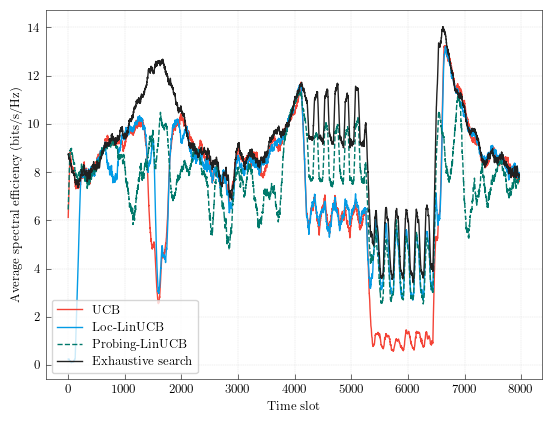

In [9]:
plt.plot(average_ucb, color='#F44336', linewidth='1', label='UCB')
plt.plot(average_loc_linucb, color='#039BE5', linewidth='1', label='Loc-LinUCB')
plt.plot(average_prob_linucb, color='#00796B', linewidth='1', linestyle='--', label='Probing-LinUCB')
plt.plot(average_optimal_SE, color='#212121', linewidth='1', label='Exhaustive search')

plt.legend(loc='lower left')
plt.xlabel('Time slot')
plt.ylabel('Average spectral efficiency (bits/s/Hz)')
plt.grid(color='gainsboro', linestyle='--', linewidth=0.3)


plt.savefig("real_time_benchmark.pdf")
plt.show()

In [10]:
print(np.mean(optimal_SE), np.mean(loc_linucb), np.mean(prob_linucb), np.mean(ucb))

9.009799150198702 7.514155371658448 7.508797126706992 7.257421526571657


In [11]:
def cdf(arr: np.array) -> list:
    
    x = range(25)
    prob = [np.sum(arr < val)/len(arr) for val in x]

    return x, prob

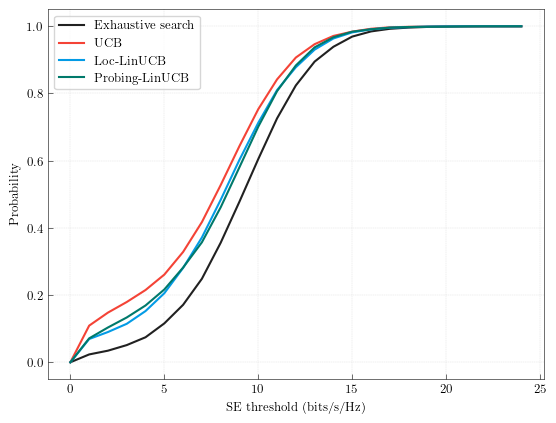

In [12]:
x_optimal, probability_optimal = cdf(optimal_SE)

x_ucb, probability_ucb = cdf(ucb)

x_loc_linucb, probability_loc_linucb = cdf(loc_linucb)

x_prob_linucb, probability_prob_linucb = cdf(prob_linucb)

plt.plot(x_optimal, probability_optimal, label='Exhaustive search', color='#212121')
plt.plot(x_ucb, probability_ucb, label='UCB', color='#F44336')
plt.plot(x_loc_linucb, probability_loc_linucb, label='Loc-LinUCB', color='#039BE5')
plt.plot(x_prob_linucb, probability_prob_linucb, label='Probing-LinUCB', color='#00796B')

plt.xlabel('SE threshold (bits/s/Hz)')
plt.ylabel('Probability')

plt.grid(color='gainsboro', linestyle='--', linewidth=0.3)
plt.legend()
plt.savefig("CDF.pdf")
plt.show()